## Анализ данных с использованием spark

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

In [2]:
spark = SparkSession.builder \
        .master('local') \
        .appName('homework_big_data') \
        .getOrCreate()

In [3]:
sql = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)

## Чтение и первичный анализ данных

Данные представлены в виде трёх csv-таблиц: таблицы оценок, информации о книгах и информации о пользователях.

In [4]:
books = spark.read.csv('BX-Books.csv', header=True, sep=';')
users = spark.read.csv('BX-Users.csv', header=True, sep=';')
ratings = spark.read.csv('BX-Book-Ratings.csv', header=True, sep=';')

In [51]:
books.registerTempTable('books')
users.registerTempTable('users')
ratings.registerTempTable('ratings')

In [7]:
print('books:\t', books.count())
print('users:\t', users.count())
print('ratings:', ratings.count())

books:	 271379
users:	 278859
ratings: 1149780


In [8]:
books.printSchema()
users.printSchema()
ratings.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)

root
 |-- User-ID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)

root
 |-- User-ID: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: string (nullable = true)



### Распределение оценок

Выведем распределение, используя модуль matplotlib

In [13]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [10]:
ratings = ratings.withColumn('Book-Rating', ratings['Book-Rating'].cast('int'))

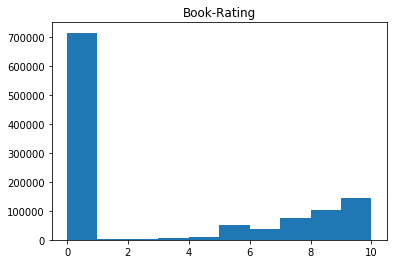

In [14]:
plt.title('Book-Rating')
plt.hist(ratings.toPandas()['Book-Rating'])
plt.show()

Полученный результат необходимо корректно интерпретировать. А именно - данное распределение не отражает реальное распределения качества книг по мнению пользователей. Причин несколько:

1) Большое количество нулевых оценок связано с тем, что многие книги не оценивал вообще никто

2) Рост оценок от 1 до 10 связан с тем, что пользователь скорее всего прочитает книгу, про которую он считает, что она ему понравится. Соответственно, оценит он её выше среднего.

### Информация о пользователях

Информация включает помимо id возраст пользователя и его местонахождение.

In [19]:
sql.sql("select * from users").show()

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|null|
|      2|stockton, califor...|  18|
|      3|moscow, yukon ter...|null|
|      4|porto, v.n.gaia, ...|  17|
|      5|farnborough, hant...|null|
|      6|santa monica, cal...|  61|
|      7| washington, dc, usa|null|
|      8|timmins, ontario,...|null|
|      9|germantown, tenne...|null|
|     10|albacete, wiscons...|  26|
|     11|melbourne, victor...|  14|
|     12|fort bragg, calif...|null|
|     13|barcelona, barcel...|  26|
|     14|mediapolis, iowa,...|null|
|     15|calgary, alberta,...|null|
|     16|albuquerque, new ...|null|
|     17|chesapeake, virgi...|null|
|     18|rio de janeiro, r...|  25|
|     19|           weston, ,|  14|
|     20|langhorne, pennsy...|  19|
+-------+--------------------+----+
only showing top 20 rows



### Самые популярные книги - топ 5

Пример использования данных для получения чего-то осмысленного. Выберем 5 самых популярных книг. К удивлению, я ни одной из них не слышал.

In [15]:
rating_count = ratings.groupby('ISBN').agg({'Book-Rating':'count'}).orderBy('count(Book-Rating)', ascending=False)
rating_count.show(5)

+----------+------------------+
|      ISBN|count(Book-Rating)|
+----------+------------------+
|0971880107|              2502|
|0316666343|              1295|
|0385504209|               883|
|0060928336|               732|
|0312195516|               723|
+----------+------------------+
only showing top 5 rows



In [25]:
sql.sql("select ISBN, 'Book-Title', Publisher  from books where ISBN in ('0971880107', '0316666343', '0385504209', '0060928336', '0312195516') ").show()

+----------+----------+-------------+
|      ISBN|Book-Title|    Publisher|
+----------+----------+-------------+
|0971880107|Book-Title|      Too Far|
|0316666343|Book-Title|Little, Brown|
|0312195516|Book-Title|  Picador USA|
|0385504209|Book-Title|    Doubleday|
|0060928336|Book-Title|    Perennial|
+----------+----------+-------------+



### Средние величины

Посмотрим на средний рейтинг и среднее количесвто голосов.

In [49]:
ratings = ratings.withColumn('Book-Rating', ratings['Book-Rating'].cast('int'))
ratings.printSchema()

root
 |-- userID: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- bookRating: integer (nullable = true)



In [45]:
def rename_columns(data, new_columns):
    from functools import reduce
    old = data.schema.names
    return reduce(lambda data, idx: data.withColumnRenamed(old[idx], new_columns[idx]), 
                  range(len(old)), data)

In [ ]:
ratings = rename_columns(ratings, ['userID', 'ISBN', 'bookRating'])

In [52]:
sql.sql("select ISBN, avg(bookRating), count(ISBN) from  ratings group by ISBN").show()

+----------+------------------+-----------+
|      ISBN|   avg(bookRating)|count(ISBN)|
+----------+------------------+-----------+
|2080674722|3.6666666666666665|          3|
|3499134004|               0.0|          1|
|3548603203|3.4166666666666665|         24|
|880781112X| 4.333333333333333|          3|
|0738205737|1.6666666666666667|          3|
|0749317256|               0.0|          1|
|0515131520|            1.6875|         16|
|8471662531|               7.0|          1|
|0441005470|               0.0|          1|
|0739417096| 5.285714285714286|          7|
|0767906373|             1.125|          8|
|0425087859|2.6666666666666665|          3|
|0553574566| 2.977777777777778|         45|
|0498024253|               3.5|          2|
|0395977894| 5.090909090909091|         44|
|0505522004|               1.4|          5|
|0425188787|3.4166666666666665|         60|
|0515137111|3.5344827586206895|         58|
|0767905385| 3.825174825174825|        143|
|0553580906| 2.341463414634146| 

## Отсечём неактивных юзеров и непопулярные книги

In [56]:
sql.sql("select userID, count(userID) from  ratings group by userID having count(userID)>=10 ").show()

+------+-------------+
|userID|count(userID)|
+------+-------------+
| 32773|          745|
|104665|          453|
|227447|         2340|
|230249|          271|
|148744|         1550|
| 92547|          268|
|131046|          941|
|241548|          406|
|126604|          214|
|212965|          372|
|274061|         1038|
| 31391|          208|
| 73394|         1804|
|162639|         1380|
|207499|          216|
| 83287|          203|
|109461|          222|
| 37712|          471|
| 88793|          202|
|217375|          851|
+------+-------------+
only showing top 20 rows



In [72]:
good_users = sql.sql("select userID, count(userID) from  ratings group by userID having count(userID)>=0 ")

In [70]:
sql.sql("select ISBN, count(ISBN) from  ratings group by ISBN having count(ISBN)>=10").show()

+----------+-----------+
|      ISBN|count(ISBN)|
+----------+-----------+
|0767905385|        143|
|0553581554|        124|
|0842329129|        297|
|0670865796|        139|
|0515135739|        102|
|034540288X|        249|
|0451156609|        170|
|044021145X|        529|
|0449219364|        171|
|0446607657|        250|
|0151008116|        170|
|0515122734|        110|
|0451167317|        153|
|043935806X|        334|
|0670892963|        131|
|0440225701|        379|
|0449134482|        121|
|0380813815|        131|
|0425151867|        100|
|0345350499|        181|
+----------+-----------+
only showing top 20 rows



In [71]:
good_books = sql.sql("select ISBN, count(ISBN) from  ratings group by ISBN having count(ISBN)>=10")

In [74]:
good_books.show()

+----------+-----------+
|      ISBN|count(ISBN)|
+----------+-----------+
|0767905385|        143|
|0553581554|        124|
|0842329129|        297|
|0670865796|        139|
|0515135739|        102|
|034540288X|        249|
|0451156609|        170|
|044021145X|        529|
|0449219364|        171|
|0446607657|        250|
|0151008116|        170|
|0515122734|        110|
|0451167317|        153|
|043935806X|        334|
|0670892963|        131|
|0440225701|        379|
|0449134482|        121|
|0380813815|        131|
|0425151867|        100|
|0345350499|        181|
+----------+-----------+
only showing top 20 rows



In [79]:
filtered_ratings = sql.sql("select * from  ratings " +
                          c"where ISBN in (select ISBN from  ratings group by ISBN having count(ISBN)>=100)"+
                          "and userID in (select userID from  ratings group by userID having count(userID)>=200)")

In [81]:
filtered_ratings.registerTempTable('filtered_ratings')

In [82]:
sql.sql("select count(*) from filtered_ratings").show()

+--------+
|count(1)|
+--------+
|   49781|
+--------+

